In [1]:
devtools::load_all("/home/ahe/tools/Lightbulb")

Loading Lightbulb
Loading required package: data.table
Loading required package: Matrix
Loading required package: Seurat
Loading required package: ggplot2
Loading required package: cowplot

Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave




### data loading

In [2]:
load("Exp_Seurat_all10_180917.Rdata") #180620
#ExpressionMat_magic=readRDS("ExpressionMat_magic.rds")

col1=c("green","black","red")
col2=rev(RColorBrewer::brewer.pal(10,"RdBu"))

batch_color=colorRampPalette(RColorBrewer::brewer.pal(9,"Set3"))(length(batchidx))
time_point_color=colorRampPalette(RColorBrewer::brewer.pal(9,"Reds"))(length(time_points))
tissue_color=RColorBrewer::brewer.pal(3,"Set2")
HVG=head(rownames(Exp_Seurat@hvg.info), 5000)

#modify for publication
time_points=toupper(time_points)
time_points[time_points=="D0"]="Naive"
Exp_Seurat@meta.data$timepoint=toupper(Exp_Seurat@meta.data$timepoint)
Exp_Seurat@meta.data$timepoint[Exp_Seurat@meta.data$timepoint=="D0"]="Naive"
batchidx=toupper(batchidx)
batchidx[batchidx=="D0_NAIVE"]="Naive"
batchidx[batchidx=="D90_MEM"]="D90"

#load specific TSNE
Exp_Seurat_Spleen=readRDS("Exp_Seurat_Spleen.Rds")
Exp_Seurat_Spleen@meta.data$timepoint=toupper(Exp_Seurat_Spleen@meta.data$timepoint)
Exp_Seurat_Spleen@meta.data$timepoint[Exp_Seurat_Spleen@meta.data$timepoint=="D0"]="Naive"

Exp_Seurat_Gut=readRDS("Exp_Seurat_Gut.Rds")
Exp_Seurat_Gut@meta.data$timepoint=toupper(Exp_Seurat_Gut@meta.data$timepoint)
Exp_Seurat_Gut@meta.data$timepoint[Exp_Seurat_Gut@meta.data$timepoint=="D0"]="Naive"

lsnofun()

[1] "batch_color"       "batchidx"          "col1"             
 [4] "col2"              "Exp_Seurat"        "Exp_Seurat_Gut"   
 [7] "Exp_Seurat_rep"    "Exp_Seurat_Spleen" "HVG"              
[10] "time_point_color"  "time_points"       "tissue_color"     
[13] "tissue_types"

### super cell creation

In [ ]:
suppressMessages(require(RANN))
suppressMessages(require(igraph))

Exp_Seurat_tmp=Exp_Seurat
Exp_Seurat_tmp@scale.data=2^Exp_Seurat_tmp@data-1
merging_out=Sampling_merging_seurat(tagSeurat=Exp_Seurat_tmp,k_filter =NULL,k_merge = 50,n=7400,sampling_ref = Exp_Seurat_tmp@meta.data$batch)
merging_out=log2(merging_out+1)
rm(Exp_Seurat_tmp)
saveRDS(merging_out,paste0("Exp_pseudoCell_nofilter.rds"))

### TSNE UMAP

In [37]:
pdf("Goldrath fig1.pdf",width=10,height=5)
par(mfrow=c(1,2))
tagC=which(Exp_Seurat_Gut@meta.data$tissue == "Gut" & Exp_Seurat_Gut@meta.data$timepoint %in% c("D4","D7","D10","D14","D21","D32","D60"))
plotByGroup(Exp_Seurat_Gut,Group_assignment=Exp_Seurat_Gut@meta.data$timepoint,main="Gut time point",tag_cell = tagC)

tagC=which(Exp_Seurat_Spleen@meta.data$tissue == "Spleen" & Exp_Seurat_Spleen@meta.data$timepoint %in% c("D4","D7","D10","D14","D21","D32","D60"))
plotByGroup(Exp_Seurat_Spleen,Group_assignment=Exp_Seurat_Spleen@meta.data$timepoint,main="Spleen time point",tag_cell = tagC)
dev.off()

png 
  2

In [10]:
Exp_Seurat_Spleen=cellcycle_assigning(Exp_Seurat_Spleen,cycle_gene_list="regev_lab_cell_cycle_genes.txt")
Exp_Seurat_Gut=cellcycle_assigning(Exp_Seurat_Gut,cycle_gene_list="regev_lab_cell_cycle_genes.txt")

In [15]:
pdf("TSNE_TPM_SpleenOnly.pdf",width=18,height=10)
par(mfrow=c(2,3))
plotByGroup(Exp_Seurat_Spleen,Group_assignment=batchidx[Exp_Seurat_Spleen@meta.data$batch],main="Batchs") #batchs
plotByGroup(Exp_Seurat_Spleen,Group_assignment=Exp_Seurat_Spleen@meta.data$timepoint,
            Group_type=time_points,main="time point",tagcol=time_point_color) #time
#plotByGroup(Exp_Seurat_Spleen,Group_assignment=as.numeric(Exp_Seurat_Spleen@ident),Addtext = T,main="cluster") 
plotByGroup(Exp_Seurat_Spleen,Group_assignment=Exp_Seurat_Spleen@meta.data$Phase,Addtext = F,main="cell cycle stage") 
dev.off()

png 
  2

In [16]:
pdf("TSNE_TPM_GutOnly.pdf",width=18,height=10)
par(mfrow=c(2,3))
plotByGroup(Exp_Seurat_Gut,Group_assignment=batchidx[Exp_Seurat_Gut@meta.data$batch],main="Batchs") #batchs
plotByGroup(Exp_Seurat_Gut,Group_assignment=Exp_Seurat_Gut@meta.data$timepoint,,main="time point",tagcol=time_point_color) #time
#plotByGroup(Exp_Seurat_Gut,Group_assignment=as.numeric(Exp_Seurat_Gut@ident),Addtext = T,main="cluster") 
plotByGroup(Exp_Seurat_Gut,Group_assignment=Exp_Seurat_Gut@meta.data$Phase,Addtext = F,main="cell cycle stage") 
dev.off()

png 
  2

## annotate cells based on bulk sample -- Spleen

In [ ]:
#replace TSNE with reruned TSNE
Exp_Seurat_rerun=readRDS("Exp_Seurat_Spleen.Rds")
cell_id1=rownames(Exp_Seurat@meta.data)
cell_id2=rownames(Exp_Seurat_rerun@meta.data)
tagC=which(cell_id1 %in% cell_id2)

Exp_Seurat@dr$tsne@cell.embeddings[-tagC,]=0
Exp_Seurat@dr$tsne@cell.embeddings[tagC,]=Exp_Seurat_rerun@dr$tsne@cell.embeddings[match(cell_id1[tagC],cell_id2),]

In [ ]:
merging_out=readRDS(paste0("Exp_pseudoCell_nofilter.rds"))

# load reference
HVG=head(rownames(Exp_Seurat@hvg.info), 1500)

LLTE_Tcm_Tem=fread("reference_Data/LLTE Tcm Tem Expression File.csv",sep=",",header=T,data.table=F)
LLTE_Tcm_Tem=LLTE_Tcm_Tem[,-2]
TE_MP=fread("reference_Data/TE MP expression file.csv",sep=",",header=T,data.table=F)

candidate_g=Reduce(intersect, list(LLTE_Tcm_Tem$NAME,TE_MP$DESCRIPTION))
common_gene=intersect(candidate_g,HVG)

In [ ]:
#Spleen
analysis_id="Spleen"
bulk_list=list(Spleen_D7=list(TE=TE_MP$D7_TE[match(common_gene,TE_MP$DESCRIPTION)],
                              MP=TE_MP$D7_MP[match(common_gene,TE_MP$DESCRIPTION)]),
               Spleen_D30=list(LLE=t(LLTE_Tcm_Tem[match(common_gene,LLTE_Tcm_Tem$NAME),2:3]),
                               TEM=t(LLTE_Tcm_Tem[match(common_gene,LLTE_Tcm_Tem$NAME),4:5]),
                               TCM=t(LLTE_Tcm_Tem[match(common_gene,LLTE_Tcm_Tem$NAME),6:7])))

bulk_list=bulk_list_normalize(bulk_list)
tag_cell_for_all_cells=which(Exp_Seurat@meta.data$tissue == "Spleen")
tag_cell=as.numeric(rownames(merging_out)) %in% tag_cell_for_all_cells
sc_mat=merging_out[tag_cell,common_gene]

In [ ]:
thresholds=c(0.75,0.75) #,0.85,0.83,0.83
pdf(width=15,height=3,file=paste0("TSNE_general_sample_set_signature_",analysis_id,".pdf"))
par(mfrow=c(1,5))
plot_SC_sampleSet_cor_TSNE(dataset,Exp_Seurat,thresholds = thresholds,color_contrast=1.5)
dev.off()

options(repr.plot.width=15, repr.plot.height=3)
par(mfrow=c(1,5))
plot_SC_sampleSet_cor_distribution(dataset)

options(repr.plot.width=15, repr.plot.height=3)
par(mfrow=c(1,5))
plot_SC_sampleSet_cor_TSNE(dataset,Exp_Seurat,thresholds = thresholds,color_contrast=1.5)

In [ ]:
dataset=secondary_cor(dataset,thresholds)

pdf(width=12,height=4,file=paste0("TSNE_celltype_signature_",analysis_id,".pdf"))
#options(repr.plot.width=12, repr.plot.height=4)
par(mfrow=c(1,3))
plot_SC_sampleSet_cor_2nd_TSNE(dataset,Exp_Seurat,plot_sets=1)
par(mfrow=c(1,3))
plot_SC_sampleSet_cor_2nd_TSNE(dataset,Exp_Seurat,plot_sets=2)
dev.off()

pdf(width=12,height=4,file=paste0("TSNE_celltype_annotation_",analysis_id,".pdf"))
#options(repr.plot.width=9, repr.plot.height=4.5)
par(mfrow=c(1,3))
plot_group_annotation_TSNE(dataset,Exp_Seurat)
dev.off()

In [ ]:
saveRDS(dataset$celltype_assignment[match(rownames(merging_out),rownames(dataset$sc_mat)),],"spleen_cell_assignment_SuperCellBased.Rds")

## annotate cells based on bulk sample -- Gut

In [ ]:
#replace TSNE with reruned TSNE
Exp_Seurat_rerun=readRDS("Exp_Seurat_Gut.Rds")
cell_id1=rownames(Exp_Seurat@meta.data)
cell_id2=rownames(Exp_Seurat_rerun@meta.data)
tagC=which(cell_id1 %in% cell_id2)

Exp_Seurat@dr$tsne@cell.embeddings[-tagC,]=0
Exp_Seurat@dr$tsne@cell.embeddings[tagC,]=Exp_Seurat_rerun@dr$tsne@cell.embeddings[match(cell_id1[tagC],cell_id2),]

In [ ]:
merging_out=readRDS(paste0("Exp_pseudoCell_nofilter.rds"))

# load reference
HVG=head(rownames(Exp_Seurat@hvg.info), 1500)
Ananda_data=fread("reference_Data/Id3Trm.gct",sep="\t",header=T,data.table=F)
Ananda_data=Ananda_data[!duplicated(Ananda_data[,1]),]
Ananda_data=Ananda_data[,c("NAME","IEL.D7.Id3hiBlimp1lo#1","IEL.D7.Id3hiBlimp1lo#2",
                           "IEL.D7.Id3loBlimp1hi#1","IEL.D7.Id3loBlimp1hi#2",
                           "IEL.D7.Id3loBlimp1lo#1","IEL.D7.Id3loBlimp1lo#2",
                           "IEL.D35.Id3hiBlimp1lo#1","IEL.D35.Id3hiBlimp1lo#2",
                           "IEL.D35.Id3loBlimp1hi#1","IEL.D35.Id3loBlimp1hi#2",
                           "IEL.D35.Id3loBlimp1lo#1","IEL.D35.Id3loBlimp1lo#2")]
rownames(Ananda_data)=Ananda_data[,1]
Ananda_data=t(Ananda_data[,-1])

LLTE_Tcm_Tem=fread("reference_Data/LLTE Tcm Tem Expression File.csv",sep=",",header=T,data.table=F)
LLTE_Tcm_Tem=LLTE_Tcm_Tem[,-2]
TE_MP=fread("reference_Data/TE MP expression file.csv",sep=",",header=T,data.table=F)

candidate_g=Reduce(intersect, list(colnames(Ananda_data),LLTE_Tcm_Tem$NAME,TE_MP$DESCRIPTION))
common_gene=intersect(candidate_g,HVG)
merging_out=merging_out[,common_gene]

In [ ]:
#IEL
analysis_id="IEL"
bulk_list=list(IEL_D7=list(D7I=Ananda_data[1:2,match(common_gene,colnames(Ananda_data))],
                           D7P=Ananda_data[3:4,match(common_gene,colnames(Ananda_data))]), #,D7none=Ananda_data[5:6,match(common_gene,colnames(Ananda_data))]
               IEL_D35=list(D35I=Ananda_data[7:8,match(common_gene,colnames(Ananda_data))],
                            D35P=Ananda_data[9:10,match(common_gene,colnames(Ananda_data))],
                            D35none=Ananda_data[11:12,match(common_gene,colnames(Ananda_data))]))

bulk_list=bulk_list_normalize(bulk_list)
tag_cell_for_all_cells=which(Exp_Seurat@meta.data$tissue == "Gut" | Exp_Seurat@meta.data$batch==1)
tag_cell=as.numeric(rownames(merging_out)) %in% tag_cell_for_all_cells
sc_mat=merging_out[tag_cell,common_gene]

In [ ]:
thresholds=c(0.70,0.6)

pdf(width=9,height=4.5,file=paste0("TSNE_general_sample_set_signature_",analysis_id,".pdf"))
par(mfrow=c(1,2))
plot_SC_sampleSet_cor_TSNE(dataset,Exp_Seurat,thresholds = thresholds,color_contrast=1.5)
dev.off()

options(repr.plot.width=6, repr.plot.height=3)
par(mfrow=c(1,2))
plot_SC_sampleSet_cor_distribution(dataset)

options(repr.plot.width=9, repr.plot.height=4.5)
par(mfrow=c(1,2))
plot_SC_sampleSet_cor_TSNE(dataset,Exp_Seurat,thresholds = thresholds,color_contrast=1.5)

In [ ]:
dataset=secondary_cor(dataset,thresholds)

pdf(width=12,height=4,file=paste0("TSNE_celltype_signature_",analysis_id,".pdf"))
#options(repr.plot.width=12, repr.plot.height=4)
par(mfrow=c(1,3))
plot_SC_sampleSet_cor_2nd_TSNE(dataset,Exp_Seurat,plot_sets=1)
par(mfrow=c(1,3))
plot_SC_sampleSet_cor_2nd_TSNE(dataset,Exp_Seurat,plot_sets=2)
dev.off()

pdf(width=9,height=4.5,file=paste0("TSNE_celltype_annotation_",analysis_id,".pdf"))
#options(repr.plot.width=9, repr.plot.height=4.5)
par(mfrow=c(1,2))
plot_group_annotation_TSNE(dataset,Exp_Seurat,tagcol=list(RColorBrewer::brewer.pal(3,"Set1")[2:1],RColorBrewer::brewer.pal(3,"Set1")[c(2,1,3)]))
dev.off()

In [ ]:
saveRDS(dataset$celltype_assignment[match(rownames(merging_out),rownames(dataset$sc_mat)),],"gut_cell_assignment_SuperCellBased.Rds")

## position TRM cells

In [4]:
Effector=c("Etfb","Unc119","Adam17","Gm8615","Ndnl2","Tbcc","Prdx4","Fancm","Mxi1","Sptlc2","Kntc1","Efhd2","Arhgap19","Ddx19b","Cyp3a16","Rab11fip4","AI597468","Usp3","AU022870","Lgals1","Serinc5","Grxcr1","Ahnak","Ccnb1","Ctsc","Alcam","Dync1li2","Fam129a","Itgb1","Rbms1","Cdk1","Cd86","Atp2a3","Shcbp1","Slc25a33","Olfr766","Usp46","Mxi1","Nipal3","Nqo2","Gsn","Racgap1","Snx5","Hiatl1","Tbkbp1","Dhx40","Spast","Idh2","4930547N16Rik","Chd7","Jup","Tmf1","Dclk2","Prr13","6330403K07Rik","Xpnpep1","Ctnnbip1","Csnk1e","Ccnb1","Pmaip1","Chd7","Stx11","Sp140","Pola1","1700017B05Rik","Gm11277","Hbb-b1","Slc4a7","Slc25a45","Nebl","Itga4","Ern1","Spc25","Hist1h2ak","4930515G01Rik","Dtl","Scd2","Ak3","Hbb-b2","Pus10","Sp140","Manba","2810417H13Rik","Prr5l","Msc","Kif22","Cercam","Osbpl8","Gm10785","Swap70","Ubash3b","Nebl","Rhoq","Ptms","Tmem165","Hist1h2bn","Cep76","Icos","Ccnb1","C330027C09Rik","Chd7","Sun1","Ccne2","Zfand5","Depdc1a","Zfp874b","Emp1","Dennd5a","Hist1h2bj","Dlgap5","Palm","Rora","Klra6","LOC100503984","E2f8","Atp6v1d","Hist1h2bk","Cited2","Glcci1","Chsy1","Cmpk1","Anln","Chd7","3110052M02Rik","Suox","Hist1h2ab","A630007B06Rik","Spag5","Dnajc1","Gm10286","Slc25a20","Cdc25b","Arntl","Chd7","Apobec2","Cenpa","Sord","Lag3","Chd7","Rnf216","Hist1h2bf","Carhsp1","Depdc1a","Serpinb6b","Casp3","2810417H13Rik","2610029I01Rik","Prune","Chd7","Olfr598","Hist1h2bm","Itga2","Gm14005","Inpp4a","Pld4","Arhgef12","Bub1b","Xlr","Pdcd1","Plek","Apaf1","Gzmk","Pycard","Plekhf1","Tspan32","Csda","Fhl2","Zfp40","2010012O05Rik","Bub1","Gabarapl1","Gna15","Igf2bp3","Osbpl3","Asna1","Rrm2","Spn","F630043A04Rik","Arhgef12","Sord","Cenpk","Chd7","Kif15","Cdk2","Nebl","Cep55","Chd7","2010002N04Rik","Irf4","Cenpe","Klra10","Casp7","Cry1","Pgm2l1","Whsc1","D330041H03Rik","Bhlhe40","Crybg3","Reep5","Trio","Tspan2","Lgals3","Chn2","Il18rap","Ddx28","Fkbp5","Cd68","Spag1","Cmklr1","Cdc20b","Klra3","S100a4","Snx10","4930447A16Rik","Lmnb1","Prc1","Rnpep","Lass6","Rnf19a","Cldnd2","Casc5","S1pr5","Galnt3","Anxa4","Gm4884","BC013712","Itgax","Hmgb2","Lxn","Hmgb2","Atoh1","Klra8","Prdm1","Zeb2","Hmgb2","Ezh2","Dock5","Havcr2","Trdn","Tpx2","Plekho1","Timp2","Nrp1","Hmgb2","Dapk2","Ncapg","As3mt","Gm10786","Kif23","Gzmb","Stmn1","Depdc1b","Arhgap11a","Ccna2","Stmn1","Rap1gap2","Car5b","Klre1","Kif11","Ccnb2","E2f2","Gem","Art2a-ps","Klrg1","Gpx8","Top2a","Mki67","Hist1h1b","Cx3cr1","Lamc1","I830127L07Rik","Esm1","Itgam","Gzma")
Memory=c("Sell","Ms4a4c","Tnfsf8","Snord47","Snord104","Snhg1","Dapl1","Bcl2","Snord49b","Snord32a","Ccr7","Dmrta1","Snhg1","Cnr2","Cxcr4","Myc","Yes1","Snord1c","Rny3","Treml2","Nsg2","Il7r","Snora61","Snord57","Aqp9","Arhgap5","Snord35a","Snora7a","Snora52","Rpl38","Parp8","Gpr183","Mettl1","Rpl38","BC005685","Ssbp2","Gm4979","Rpl38","Nt5e","Snhg1","Samd3","Inpp4b","Zbtb20","Cd55","Rpl39","Apol7b","Apol7e","Gm12191","Atn1","ND3","Ly6a","BC005685","Cd7","Rpl39","Qser1","Ddx60","BC005685","Tnf","Btla","Srm","Rpl38","Gm12191","Zbtb20","Gm12191","Snora23","Snora44","Gm12191","Gm12191","LOC641050","Fam46c","Prss12","Tuba1b","LOC641050","D17H6S56E-5","Gm12191","E430029J22Rik","Cd2ap","Prrg4","Rpl36","Ttc28","Fam101b","Vwa5a","4930420K17Rik","Gm12191","Gm12191","Gm12191","AB041803","Snora69","Gas5","Gm12191","Parp12","Nop10","Tcf7","Rps18","Rpl36a","Mtx3","Snora3","Tmx2","Mif","Polr1b","Gpr114","Gnl3","Il6st","Rpl36","Rpl36","Nop58","Rpl36","Plekha1","Pprc1","Rpl36","Rpl30","Bcl2","Rpl36a","Rpl36","Dse","Mir342","Rny1","Rpl36","Dph5","Gm11968","Il4ra","Mif","Mif","LOC641050","Rpl41","Rps18","Ctss","Rps18","Tgtp1","LOC641050","Tmx2","Rplp1","Rrp15","Dzip1","Snora3","Mdn1","Rps15a","Rps28","Rps15a","Crim1","Rpl36a","Mrpl23","Rps18","Crtam","Rtp4","Rps18","Rnf130","Apex1","Il2ra","Rps18","Rpl36","Rps16","Nop56","Xcl1","Rps18","Mrps18b","Slfn5","Tgtp1","Qser1","Rps16","Rpl12","Cd69","Rplp1","Spint2","Rpl36","Ptges3","Dennd2d","Rps15","Gm14420","Slfn1","Ttc27","Pde2a","Gpatch4","Mrpl23","Mrpl52","Rps16","Mybbp1a","Smyd5","Zfp238","Rpl10","Sh3bp5","Rpl12","Gas5","Rpl12","Ptges3","Dus4l","Kcnj8","Tubb5","5830405N20Rik","Rgs10","Rps28","Cd72","Utp20","Rpl12","Ttc28","Gas5","Gm14326","Tsr1","Abca1","Rpl12","2610019F03Rik","Gm14391","Ccdc101","2410002F23Rik","1600012F09Rik","Rpl10","Tnfsf10","Ppp1r14b","Gm16489","Atpbd4","Gbe1","Snhg1","Qtrtd1","Tuba1b","Enpp5","Wdr49","B230307C23Rik","Atp6v0d2","Myo3b","Gm14326","Btbd11","Pam","Rpl12","Taf4b","Rpl12","Rpl10","Hexa","Tuba1b","Ly6e","Rpl10","Vkorc1","Trim30d","Zcwpw1","Ube2cbp","Vars","Rpl10","Rpl10","Snord53","Cdh1","Dock9","Scarna13","Paics","Inadl","1700021A07Rik","Snord8","Arrb1","Sigmar1","Nr1d2","Nr1d1","Mir29c","A630038E17Rik","Smyd2","Mmachc","Rps27","Insr","Rpsa","Ccnd2","Rpl35","Ppp1r14b","Mid1","Ssh2","Dkc1","Pex3","Rcl1","Snord95","Rpl9","Mthfd1","Rpp38","AI480653","Rps5","Ppih","Rpl9","Fam125b","Snrpg","Sesn3","Hspe1","Rpl35","Rpl9","Ppih","Pisd-ps1","Rpl35","Gsto1","Traf1","Fam102a","Trmt61a","Hsp90aa1","Eef1e1","Bckdhb","Farsb","Gm14403","Ust","Rpl9","Tnfrsf18","Ikbkb","Hsd17b11","Cisd1","Rpl9","Hook1","Fastkd2","Elovl5","BC016423","Tmem38b","Tuba4a","Pros1","Ptma","Rpl23a","Mki67ip","Thada","Hs3st3b1","Nek1","Ptma","Rps15","4732471D19Rik","Ergic1","Pltp","Evl","Mars2","Psme1","Naa25","Hipk2","Impdh2","Thra","Rab6b","Efha2","Entpd6","Rpl9","Rpl9","Mat2a","D130062J21Rik","Rpp40","Dhdds","Ndufa4","Hspe1","Rps9","Psmg1","Rpl27","Tmem63a","Rnf141","Rpl27a","Wwp1","Tuba1c","Rabggtb","Rps26","C230055K05Rik","Enpp4","Gapdhs","Rps15","P2ry10","Timm10","Tasp1","Tpi1","Rps27","Gstp1","Spef2","Rps26","Xrcc5","Ass1","Zeb1","Sfxn1","Slc14a1","Ddx18","Mtg1","Rps3","Bmpr1a","Hvcn1","Tspan13","Fam46a","Dguok","Rps26","Unc5a","Abce1","2610030H06Rik","Ppih","Heatr5a","Vipr1","Zscan12","Rpl31","Pdlim1","Ptma","Ddx56","Timm8a1","Rpl9","Mcoln2","Rplp1","Polr1a","Tnfrsf22","Bach2","Fchsd2","Ifrd2","Pdk2","Ass1","Snora62","Trmt5","Rps12","Rrp1b","Cbx7","Coro2a","BC048403","Gng5","Fam169b","Cd93","Ppih","Pilrb2","Naa10","Slc7a5","B230315N10Rik","Dzip1","Rundc3b","Rpl23","Emb","Ifi30","Mov10","Prdx6","Tspan31","Rps12","H2-Ob","Rab37","Ier3","Map4k3","Kbtbd11","Ppie","Rps12","Hus1","Gstk1","Snx16","Gas7","Fam116b","Rps10","Tnfrsf26","Fpgt","Uxt","Gm9457","Grwd1","Prrg1","Rpl15","Wdr12","Rpl27a","Oasl2","Trmt1","Tmem48","Mgrn1","Cst7","Gm5244","Polr3e","Nme2","6530401N04Rik","Utp15","Bnip3","Edaradd","Rpl15","Yars2","Rpl21-ps10","Lmbr1","BC057079","Rpl41","Tsga10ip","Lpar5","Slc11a2","Rnf122","Ndufaf4","Bbs2","Eif4a2","Rpl21","Sit1","Cdk4","Dtx4","Rpl15","Rpl21","Mrpl38","Rps12","Atp8a2","Uba52","0610037L13Rik","Snora21","Ddx51","Heatr1","Ipo4","Trmt112","Slc12a7","Rpl15","2410066E13Rik","Polr2e","Mmab","Rpl27a","Rps12","Rpl21","Trove2","Gart","Tdrd7","Trmt112","Wbscr27","Smyd3","Gm10345","Rpl21","Taf1d","Hsp90ab1","Rpl29","Gm9104","Rpl15","Rpl27a","Exosc1","Rps12","Rpl21","Rpl29","Naip5","Abhd14b","Gpr97","Rpl21","Eral1","Rpl29","Rapgef6","Zdhhc23","Eef2k","Gm5921","Urb1","Rpl29","Pebp1","Gm4983","Rpl15","Gm13139","Acvr2a","6330409N04Rik","Polr3e","Mboat1","Rps10","Rpl10a","Atg14","Dnajb2","Tcfap4","Ehd3","Satb1","Hsd17b12","Rpl21","Dennd4a","Jmjd8","Celsr1","Haus5","Suclg2","Sil1","Nat10","Rpl21","Rpl27a","Pebp1","Nr2c1","Rpl31","Dkkl1","Mrpl35","C1qbp","Faah","Nop16","Ampd3","Rpl21","D630037F22Rik","Timm8a1","Fcgr2b","Rpl31","Rnf144a","Dock6","Dctd","Il6ra","Slc7a1","Alg8","Pdlim1","Rpl32","Wdr12","Cd44","Aldoa","Gm9104","Rpl21","Rpl10a","Rps14","Abcc1","Rpl21","Rpl21","Fam122b","Rnaseh2a","Gm9104","Rpl21","Erich1","Mipep","B3galt6","Gm9104","Nme1","Rps28","Rpl21","Rpl21","Rpl31","Rpl27a","Gm9104","Wdr36","Fntb","Rpl27a","Gm9104","Abhd6","Vmn2r86","Dynlt3","Rps10","Rpl21","4933439F18Rik","Il10rb","Slc26a11","Rpl21","Acvr1b","Il2rb","Tfrc","Rpl11","Serpina3f","Cenpt","Vmn2r29","Aldh6a1","Rpl10a","Zfp280d","Pa2g4","Zmat1","Rps2","Pomt1","Mapk11","Trim12a","Lipo1","Rabac1","Gm9104","Rpl31","Neurl3","Rpl21","Bcl7a","Rpl21","Rpl27a","Cnbp","Brix1","Ltb","Rpl21","Rpl10a","Chic1","Fam134b","Alg1","1700021C14Rik","Ctdsp2","Cnrip1","Suclg2","Zhx2","Plrg1","Rpl21","Gramd4","Entpd5","Olfr316","Rps2","Echdc1","Tpt1","Abhd11","Rpl3","Rps8","Bat1a","Wdr46","Gpr155","Rpl21","Pwp2","Fpgs","Snora21","BC049349","Ms4a4a","Wdr18","Nol6","Rpl13","Gaa","Rpl27a","Rpl21","Dirc2","Zfp110","Pou6f1","Pgm3","Ift172","Gtpbp4","4930522L14Rik","Ndufa5","Herpud1","Rps2","Rpl13","Dtx1","Rps2","Rps2","Lyplal1","Trio","Rpl13","Rpl13","Rpl13","Rpl13","Rps2","Rps24","Rps2","Rps2","Pkp4","Socs3","Arhgap39","Rps2","Prmt7","Tsr2","Gpx1","Rps2","Acsl1","Rps2","Rps2","Rps2","Rps2","Pus7","Rpl23a","Surf2","AB124611","Rps2","Rps24","Rps2","Trp53","Slc19a1","Scamp4","Foxp1","Hectd2","Rpl8","Btbd19","Rpl23a","Thoc1","Zfp781","Rpl13","Nle1","Dars","Rps23","Cad","A2ld1")
#HVG=head(rownames(Exp_Seurat@hvg.info), 2000)
#Effector=Effector[Effector %in% HVG]
#Memory=Memory[Memory %in% HVG]

super_cells=readRDS(paste0("Exp_pseudoCell_nofilter.rds"))
super_cells_metadata=Exp_Seurat@meta.data[as.numeric(rownames(super_cells)),]
super_cells_annotation_spleen=readRDS("spleen_cell_assignment_SuperCellBased.Rds")
super_cells_annotation_gut=readRDS("gut_cell_assignment_SuperCellBased.Rds")

Spleen_cells_touse=which(super_cells_metadata$tissue == "Spleen" & super_cells_metadata$timepoint %in% c("D4","D7","D10","D14","D21","D32","D60"))
Gut_cells_touse=which(super_cells_metadata$tissue == "Gut" & super_cells_metadata$timepoint %in% c("D4","D7","D10","D14","D21","D32","D60"))
super_cells_spleen=super_cells[Spleen_cells_touse,]
super_cells_gut=super_cells[Gut_cells_touse,]

super_cells_metadata_spleen=super_cells_metadata[Spleen_cells_touse,]
super_cells_metadata_gut=super_cells_metadata[Gut_cells_touse,]
super_cells_annotation_spleen=super_cells_annotation_spleen[Spleen_cells_touse,]
super_cells_annotation_gut=super_cells_annotation_gut[Gut_cells_touse,]

In [5]:
pc_supercell_spleen=prcomp(super_cells_spleen[,colnames(super_cells) %in% c(Effector,Memory)])
pc_supercell_gut_cood=scale(super_cells_gut[,colnames(super_cells) %in% c(Effector,Memory)],
                            pc_supercell_spleen$center,
                            pc_supercell_spleen$scale) %*% pc_supercell_spleen$rotation 

In [6]:
cell_type_to_plot=c("Spleen D4","Spleen D7 TE","Spleen D7 MP","Spleen D60 LLE","Spleen D60 Tem/Tcm")
cell_type_vector=rep(length(cell_type_to_plot)+1,nrow(pc_supercell_spleen$x))
cell_type_vector[super_cells_metadata_spleen$tissue == "Spleen" & super_cells_metadata_spleen$timepoint == "D4"]=1
cell_type_vector[super_cells_metadata_spleen$tissue == "Spleen" & super_cells_metadata_spleen$timepoint == "D7" & super_cells_annotation_spleen$Spleen_D7 == "TE"]=2
cell_type_vector[super_cells_metadata_spleen$tissue == "Spleen" & super_cells_metadata_spleen$timepoint == "D7" & super_cells_annotation_spleen$Spleen_D7 == "MP"]=3
cell_type_vector[super_cells_metadata_spleen$tissue == "Spleen" & super_cells_metadata_spleen$timepoint == "D60" & super_cells_annotation_spleen$Spleen_D30 == "LLE"]=4
cell_type_vector[super_cells_metadata_spleen$tissue == "Spleen" & super_cells_metadata_spleen$timepoint == "D60" & super_cells_annotation_spleen$Spleen_D30 != "LLE"]=5

coltouse=RColorBrewer::brewer.pal(length(cell_type_to_plot),"Set3")

xmax=max(pc_supercell_spleen$x[,1])+(max(pc_supercell_spleen$x[,1])-min(pc_supercell_spleen$x[,1]))*0.3
xmin=min(pc_supercell_spleen$x[,1])
ymax=max(pc_supercell_spleen$x[,2])
ymin=min(pc_supercell_spleen$x[,2])

annotation_to_plot=c("D35I","D35P","D35none")
annotation_col=RColorBrewer::brewer.pal(3,"Set1")[c(2,1,3)]

pdf("Comparing_spleen&gut_in_EffectorMemoryGeneSpace_GutD35signal.pdf",width=15,height=12)
par(mfrow=c(3,3))
plot(pc_supercell_spleen$x[cell_type_vector==length(cell_type_to_plot)+1,1:2],col="gray87",pch=19,xlim=c(xmin,xmax),ylim=c(ymin,ymax))
points(pc_supercell_spleen$x[cell_type_vector!=length(cell_type_to_plot)+1,1:2],col=coltouse[cell_type_vector][cell_type_vector!=6],pch=19)
legend("topright",cell_type_to_plot,col=coltouse,bty = "n",pch=19)

tag_time=c("D4","D7","D10","D14","D21","D32","D60")
for(i in 1:length(tag_time)){
    plot(pc_supercell_spleen$x[cell_type_vector!=length(cell_type_to_plot)+1,1:2],col=coltouse[cell_type_vector][cell_type_vector!=6],
         pch=19,main=paste0("Gut_",tag_time[i]),xlim=c(xmin,xmax),ylim=c(ymin,ymax))
    tagcells=super_cells_metadata_gut$tissue == "Gut" & super_cells_metadata_gut$timepoint == tag_time[i]
    colvector=annotation_col[match(super_cells_annotation_gut$IEL_D35[tagcells],annotation_to_plot)]
    colvector[is.na(colvector)]="gray"
    points(pc_supercell_gut_cood[tagcells,1:2],col=colvector)
    legend("topright",c(annotation_to_plot,"NA"),col=c(annotation_col,"gray"),bty = "n",pch=1)
}
dev.off()

annotation_to_plot=c("D7I","D7P")
annotation_col=RColorBrewer::brewer.pal(3,"Set1")[2:1]

pdf("Comparing_spleen&gut_in_EffectorMemoryGeneSpace_GutD7signal.pdf",width=15,height=12)
par(mfrow=c(3,3))
plot(pc_supercell_spleen$x[cell_type_vector==length(cell_type_to_plot)+1,1:2],col="gray87",pch=19,xlim=c(xmin,xmax),ylim=c(ymin,ymax))
points(pc_supercell_spleen$x[cell_type_vector!=length(cell_type_to_plot)+1,1:2],col=coltouse[cell_type_vector][cell_type_vector!=6],pch=19)
legend("topright",cell_type_to_plot,col=coltouse,bty = "n",pch=19)

tag_time=c("D4","D7","D10","D14","D21","D32","D60")
for(i in 1:length(tag_time)){
    plot(pc_supercell_spleen$x[cell_type_vector!=length(cell_type_to_plot)+1,1:2],col=coltouse[cell_type_vector][cell_type_vector!=6],
         pch=19,main=paste0("Gut_",tag_time[i]),xlim=c(xmin,xmax),ylim=c(ymin,ymax))
    tagcells=super_cells_metadata_gut$tissue == "Gut" & super_cells_metadata_gut$timepoint == tag_time[i]
    colvector=annotation_col[match(super_cells_annotation_gut$IEL_D7[tagcells],annotation_to_plot)]
    colvector[is.na(colvector)]="gray"
    points(pc_supercell_gut_cood[tagcells,1:2],col=colvector)
    legend("topright",c(annotation_to_plot,"NA"),col=c(annotation_col,"gray"),bty = "n",pch=1)
}
dev.off()

png 
  2

png 
  2

### annotating just by gene

In [3]:
TCR_pathway=c("AKT1","AKT2","AKT3","BCL10","CARD11","CBL","CBLB","CBLC","CD247","CD28","CD3D","CD3E","CD3G","CD4","CD40LG","CD8A","CD8B","CDC42","CDK4","CHP","CHP2","CHUK","CSF2","CTLA4","DLG1","FOS","FYN","GRAP2","GRB2","GSK3B","HRAS","ICOS","IFNG","IKBKB","IKBKG","IL10","IL2","IL4","IL5","ITK","JUN","KRAS","LAT","LCK","LCP2","MALT1","MAP2K1","MAP2K2","MAP2K7","MAP3K14","MAP3K7","MAP3K8","MAPK1","MAPK11","MAPK12","MAPK13","MAPK14","MAPK3","MAPK9","NCK1","NCK2","NFAT5","NFATC1","NFATC2","NFATC3","NFATC4","NFKB1","NFKBIA","NFKBIB","NFKBIE","NRAS","PAK1","PAK2","PAK3","PAK4","PAK6","PAK7","PDCD1","PDPK1","PIK3CA","PIK3CB","PIK3CD","PIK3CG","PIK3R1","PIK3R2","PIK3R3","PIK3R5","PLCG1","PPP3CA","PPP3CB","PPP3CC","PPP3R1","PPP3R2","PRKCQ","PTPN6","PTPRC","RAF1","RASGRP1","RELA","RHOA","SOS1","SOS2","TEC","TNF","VAV1","VAV2","VAV3","ZAP70")
Effector=c("Etfb","Unc119","Adam17","Gm8615","Ndnl2","Tbcc","Prdx4","Fancm","Mxi1","Sptlc2","Kntc1","Efhd2","Arhgap19","Ddx19b","Cyp3a16","Rab11fip4","AI597468","Usp3","AU022870","Lgals1","Serinc5","Grxcr1","Ahnak","Ccnb1","Ctsc","Alcam","Dync1li2","Fam129a","Itgb1","Rbms1","Cdk1","Cd86","Atp2a3","Shcbp1","Slc25a33","Olfr766","Usp46","Mxi1","Nipal3","Nqo2","Gsn","Racgap1","Snx5","Hiatl1","Tbkbp1","Dhx40","Spast","Idh2","4930547N16Rik","Chd7","Jup","Tmf1","Dclk2","Prr13","6330403K07Rik","Xpnpep1","Ctnnbip1","Csnk1e","Ccnb1","Pmaip1","Chd7","Stx11","Sp140","Pola1","1700017B05Rik","Gm11277","Hbb-b1","Slc4a7","Slc25a45","Nebl","Itga4","Ern1","Spc25","Hist1h2ak","4930515G01Rik","Dtl","Scd2","Ak3","Hbb-b2","Pus10","Sp140","Manba","2810417H13Rik","Prr5l","Msc","Kif22","Cercam","Osbpl8","Gm10785","Swap70","Ubash3b","Nebl","Rhoq","Ptms","Tmem165","Hist1h2bn","Cep76","Icos","Ccnb1","C330027C09Rik","Chd7","Sun1","Ccne2","Zfand5","Depdc1a","Zfp874b","Emp1","Dennd5a","Hist1h2bj","Dlgap5","Palm","Rora","Klra6","LOC100503984","E2f8","Atp6v1d","Hist1h2bk","Cited2","Glcci1","Chsy1","Cmpk1","Anln","Chd7","3110052M02Rik","Suox","Hist1h2ab","A630007B06Rik","Spag5","Dnajc1","Gm10286","Slc25a20","Cdc25b","Arntl","Chd7","Apobec2","Cenpa","Sord","Lag3","Chd7","Rnf216","Hist1h2bf","Carhsp1","Depdc1a","Serpinb6b","Casp3","2810417H13Rik","2610029I01Rik","Prune","Chd7","Olfr598","Hist1h2bm","Itga2","Gm14005","Inpp4a","Pld4","Arhgef12","Bub1b","Xlr","Pdcd1","Plek","Apaf1","Gzmk","Pycard","Plekhf1","Tspan32","Csda","Fhl2","Zfp40","2010012O05Rik","Bub1","Gabarapl1","Gna15","Igf2bp3","Osbpl3","Asna1","Rrm2","Spn","F630043A04Rik","Arhgef12","Sord","Cenpk","Chd7","Kif15","Cdk2","Nebl","Cep55","Chd7","2010002N04Rik","Irf4","Cenpe","Klra10","Casp7","Cry1","Pgm2l1","Whsc1","D330041H03Rik","Bhlhe40","Crybg3","Reep5","Trio","Tspan2","Lgals3","Chn2","Il18rap","Ddx28","Fkbp5","Cd68","Spag1","Cmklr1","Cdc20b","Klra3","S100a4","Snx10","4930447A16Rik","Lmnb1","Prc1","Rnpep","Lass6","Rnf19a","Cldnd2","Casc5","S1pr5","Galnt3","Anxa4","Gm4884","BC013712","Itgax","Hmgb2","Lxn","Hmgb2","Atoh1","Klra8","Prdm1","Zeb2","Hmgb2","Ezh2","Dock5","Havcr2","Trdn","Tpx2","Plekho1","Timp2","Nrp1","Hmgb2","Dapk2","Ncapg","As3mt","Gm10786","Kif23","Gzmb","Stmn1","Depdc1b","Arhgap11a","Ccna2","Stmn1","Rap1gap2","Car5b","Klre1","Kif11","Ccnb2","E2f2","Gem","Art2a-ps","Klrg1","Gpx8","Top2a","Mki67","Hist1h1b","Cx3cr1","Lamc1","I830127L07Rik","Esm1","Itgam","Gzma")
Memory=c("Sell","Ms4a4c","Tnfsf8","Snord47","Snord104","Snhg1","Dapl1","Bcl2","Snord49b","Snord32a","Ccr7","Dmrta1","Snhg1","Cnr2","Cxcr4","Myc","Yes1","Snord1c","Rny3","Treml2","Nsg2","Il7r","Snora61","Snord57","Aqp9","Arhgap5","Snord35a","Snora7a","Snora52","Rpl38","Parp8","Gpr183","Mettl1","Rpl38","BC005685","Ssbp2","Gm4979","Rpl38","Nt5e","Snhg1","Samd3","Inpp4b","Zbtb20","Cd55","Rpl39","Apol7b","Apol7e","Gm12191","Atn1","ND3","Ly6a","BC005685","Cd7","Rpl39","Qser1","Ddx60","BC005685","Tnf","Btla","Srm","Rpl38","Gm12191","Zbtb20","Gm12191","Snora23","Snora44","Gm12191","Gm12191","LOC641050","Fam46c","Prss12","Tuba1b","LOC641050","D17H6S56E-5","Gm12191","E430029J22Rik","Cd2ap","Prrg4","Rpl36","Ttc28","Fam101b","Vwa5a","4930420K17Rik","Gm12191","Gm12191","Gm12191","AB041803","Snora69","Gas5","Gm12191","Parp12","Nop10","Tcf7","Rps18","Rpl36a","Mtx3","Snora3","Tmx2","Mif","Polr1b","Gpr114","Gnl3","Il6st","Rpl36","Rpl36","Nop58","Rpl36","Plekha1","Pprc1","Rpl36","Rpl30","Bcl2","Rpl36a","Rpl36","Dse","Mir342","Rny1","Rpl36","Dph5","Gm11968","Il4ra","Mif","Mif","LOC641050","Rpl41","Rps18","Ctss","Rps18","Tgtp1","LOC641050","Tmx2","Rplp1","Rrp15","Dzip1","Snora3","Mdn1","Rps15a","Rps28","Rps15a","Crim1","Rpl36a","Mrpl23","Rps18","Crtam","Rtp4","Rps18","Rnf130","Apex1","Il2ra","Rps18","Rpl36","Rps16","Nop56","Xcl1","Rps18","Mrps18b","Slfn5","Tgtp1","Qser1","Rps16","Rpl12","Cd69","Rplp1","Spint2","Rpl36","Ptges3","Dennd2d","Rps15","Gm14420","Slfn1","Ttc27","Pde2a","Gpatch4","Mrpl23","Mrpl52","Rps16","Mybbp1a","Smyd5","Zfp238","Rpl10","Sh3bp5","Rpl12","Gas5","Rpl12","Ptges3","Dus4l","Kcnj8","Tubb5","5830405N20Rik","Rgs10","Rps28","Cd72","Utp20","Rpl12","Ttc28","Gas5","Gm14326","Tsr1","Abca1","Rpl12","2610019F03Rik","Gm14391","Ccdc101","2410002F23Rik","1600012F09Rik","Rpl10","Tnfsf10","Ppp1r14b","Gm16489","Atpbd4","Gbe1","Snhg1","Qtrtd1","Tuba1b","Enpp5","Wdr49","B230307C23Rik","Atp6v0d2","Myo3b","Gm14326","Btbd11","Pam","Rpl12","Taf4b","Rpl12","Rpl10","Hexa","Tuba1b","Ly6e","Rpl10","Vkorc1","Trim30d","Zcwpw1","Ube2cbp","Vars","Rpl10","Rpl10","Snord53","Cdh1","Dock9","Scarna13","Paics","Inadl","1700021A07Rik","Snord8","Arrb1","Sigmar1","Nr1d2","Nr1d1","Mir29c","A630038E17Rik","Smyd2","Mmachc","Rps27","Insr","Rpsa","Ccnd2","Rpl35","Ppp1r14b","Mid1","Ssh2","Dkc1","Pex3","Rcl1","Snord95","Rpl9","Mthfd1","Rpp38","AI480653","Rps5","Ppih","Rpl9","Fam125b","Snrpg","Sesn3","Hspe1","Rpl35","Rpl9","Ppih","Pisd-ps1","Rpl35","Gsto1","Traf1","Fam102a","Trmt61a","Hsp90aa1","Eef1e1","Bckdhb","Farsb","Gm14403","Ust","Rpl9","Tnfrsf18","Ikbkb","Hsd17b11","Cisd1","Rpl9","Hook1","Fastkd2","Elovl5","BC016423","Tmem38b","Tuba4a","Pros1","Ptma","Rpl23a","Mki67ip","Thada","Hs3st3b1","Nek1","Ptma","Rps15","4732471D19Rik","Ergic1","Pltp","Evl","Mars2","Psme1","Naa25","Hipk2","Impdh2","Thra","Rab6b","Efha2","Entpd6","Rpl9","Rpl9","Mat2a","D130062J21Rik","Rpp40","Dhdds","Ndufa4","Hspe1","Rps9","Psmg1","Rpl27","Tmem63a","Rnf141","Rpl27a","Wwp1","Tuba1c","Rabggtb","Rps26","C230055K05Rik","Enpp4","Gapdhs","Rps15","P2ry10","Timm10","Tasp1","Tpi1","Rps27","Gstp1","Spef2","Rps26","Xrcc5","Ass1","Zeb1","Sfxn1","Slc14a1","Ddx18","Mtg1","Rps3","Bmpr1a","Hvcn1","Tspan13","Fam46a","Dguok","Rps26","Unc5a","Abce1","2610030H06Rik","Ppih","Heatr5a","Vipr1","Zscan12","Rpl31","Pdlim1","Ptma","Ddx56","Timm8a1","Rpl9","Mcoln2","Rplp1","Polr1a","Tnfrsf22","Bach2","Fchsd2","Ifrd2","Pdk2","Ass1","Snora62","Trmt5","Rps12","Rrp1b","Cbx7","Coro2a","BC048403","Gng5","Fam169b","Cd93","Ppih","Pilrb2","Naa10","Slc7a5","B230315N10Rik","Dzip1","Rundc3b","Rpl23","Emb","Ifi30","Mov10","Prdx6","Tspan31","Rps12","H2-Ob","Rab37","Ier3","Map4k3","Kbtbd11","Ppie","Rps12","Hus1","Gstk1","Snx16","Gas7","Fam116b","Rps10","Tnfrsf26","Fpgt","Uxt","Gm9457","Grwd1","Prrg1","Rpl15","Wdr12","Rpl27a","Oasl2","Trmt1","Tmem48","Mgrn1","Cst7","Gm5244","Polr3e","Nme2","6530401N04Rik","Utp15","Bnip3","Edaradd","Rpl15","Yars2","Rpl21-ps10","Lmbr1","BC057079","Rpl41","Tsga10ip","Lpar5","Slc11a2","Rnf122","Ndufaf4","Bbs2","Eif4a2","Rpl21","Sit1","Cdk4","Dtx4","Rpl15","Rpl21","Mrpl38","Rps12","Atp8a2","Uba52","0610037L13Rik","Snora21","Ddx51","Heatr1","Ipo4","Trmt112","Slc12a7","Rpl15","2410066E13Rik","Polr2e","Mmab","Rpl27a","Rps12","Rpl21","Trove2","Gart","Tdrd7","Trmt112","Wbscr27","Smyd3","Gm10345","Rpl21","Taf1d","Hsp90ab1","Rpl29","Gm9104","Rpl15","Rpl27a","Exosc1","Rps12","Rpl21","Rpl29","Naip5","Abhd14b","Gpr97","Rpl21","Eral1","Rpl29","Rapgef6","Zdhhc23","Eef2k","Gm5921","Urb1","Rpl29","Pebp1","Gm4983","Rpl15","Gm13139","Acvr2a","6330409N04Rik","Polr3e","Mboat1","Rps10","Rpl10a","Atg14","Dnajb2","Tcfap4","Ehd3","Satb1","Hsd17b12","Rpl21","Dennd4a","Jmjd8","Celsr1","Haus5","Suclg2","Sil1","Nat10","Rpl21","Rpl27a","Pebp1","Nr2c1","Rpl31","Dkkl1","Mrpl35","C1qbp","Faah","Nop16","Ampd3","Rpl21","D630037F22Rik","Timm8a1","Fcgr2b","Rpl31","Rnf144a","Dock6","Dctd","Il6ra","Slc7a1","Alg8","Pdlim1","Rpl32","Wdr12","Cd44","Aldoa","Gm9104","Rpl21","Rpl10a","Rps14","Abcc1","Rpl21","Rpl21","Fam122b","Rnaseh2a","Gm9104","Rpl21","Erich1","Mipep","B3galt6","Gm9104","Nme1","Rps28","Rpl21","Rpl21","Rpl31","Rpl27a","Gm9104","Wdr36","Fntb","Rpl27a","Gm9104","Abhd6","Vmn2r86","Dynlt3","Rps10","Rpl21","4933439F18Rik","Il10rb","Slc26a11","Rpl21","Acvr1b","Il2rb","Tfrc","Rpl11","Serpina3f","Cenpt","Vmn2r29","Aldh6a1","Rpl10a","Zfp280d","Pa2g4","Zmat1","Rps2","Pomt1","Mapk11","Trim12a","Lipo1","Rabac1","Gm9104","Rpl31","Neurl3","Rpl21","Bcl7a","Rpl21","Rpl27a","Cnbp","Brix1","Ltb","Rpl21","Rpl10a","Chic1","Fam134b","Alg1","1700021C14Rik","Ctdsp2","Cnrip1","Suclg2","Zhx2","Plrg1","Rpl21","Gramd4","Entpd5","Olfr316","Rps2","Echdc1","Tpt1","Abhd11","Rpl3","Rps8","Bat1a","Wdr46","Gpr155","Rpl21","Pwp2","Fpgs","Snora21","BC049349","Ms4a4a","Wdr18","Nol6","Rpl13","Gaa","Rpl27a","Rpl21","Dirc2","Zfp110","Pou6f1","Pgm3","Ift172","Gtpbp4","4930522L14Rik","Ndufa5","Herpud1","Rps2","Rpl13","Dtx1","Rps2","Rps2","Lyplal1","Trio","Rpl13","Rpl13","Rpl13","Rpl13","Rps2","Rps24","Rps2","Rps2","Pkp4","Socs3","Arhgap39","Rps2","Prmt7","Tsr2","Gpx1","Rps2","Acsl1","Rps2","Rps2","Rps2","Rps2","Pus7","Rpl23a","Surf2","AB124611","Rps2","Rps24","Rps2","Trp53","Slc19a1","Scamp4","Foxp1","Hectd2","Rpl8","Btbd19","Rpl23a","Thoc1","Zfp781","Rpl13","Nle1","Dars","Rps23","Cad","A2ld1")

TCR_pathway=firstup(TCR_pathway)
TCR_pathway=TCR_pathway[TCR_pathway %in% rownames(Exp_Seurat_Gut@data)]
Effector=Effector[Effector %in% rownames(Exp_Seurat_Gut@data)]
Memory=Memory[Memory %in% rownames(Exp_Seurat_Gut@data)]

Gene_list=list(#TCR_Activation=TCR_pathway,
               Effector=Effector,
               Memory=Memory)
Module_score_Gut=AddModuleScore(Exp_Seurat_Gut,genes.list = Gene_list,
                            ctrl.size = min(vapply(X = Gene_list, FUN = length, FUN.VALUE = numeric(1))))
Module_score_Spleen=AddModuleScore(Exp_Seurat_Spleen,genes.list = Gene_list,
                            ctrl.size = min(vapply(X = Gene_list, FUN = length, FUN.VALUE = numeric(1))))

In [4]:
options(repr.plot.width=8, repr.plot.height=8)

pdf("TSNE_TPM_Effector_Memory_SignatureGeneScore.pdf",width=8,height=8)
par(mfrow=c(2,2))
plotByScore(Exp_Seurat_Gut,Score_assignment = Module_score_Gut@meta.data$Cluster1,target_dot_number = 5000,main_title = "Gut_Effector")
plotByScore(Exp_Seurat_Gut,Score_assignment = Module_score_Gut@meta.data$Cluster2,target_dot_number = 5000,main_title = "Gut_Memory")
plotByScore(Exp_Seurat_Spleen,Score_assignment = Module_score_Spleen@meta.data$Cluster1,target_dot_number = 5000,main_title = "Spleen_Effector")
plotByScore(Exp_Seurat_Spleen,Score_assignment = Module_score_Spleen@meta.data$Cluster2,target_dot_number = 5000,main_title = "Spleen_Memory")
dev.off()

png 
  2

In [7]:
timepoints=c("D4","D7","D10","D14","D21","D32","D60")
pdf("TSNE_TPM_Effector_Memory_SignatureGeneScore_bytimepoint.pdf",width=8,height=28)
par(mfrow=c(7,2))
for(i in 1:length(timepoints)){
    tagC=which(Exp_Seurat_Gut@meta.data$timepoint %in% timepoints[i])
    plotByScore(Exp_Seurat_Gut,Score_assignment = Module_score_Gut@meta.data$Cluster1,target_dot_number = 5000,
                main_title = paste0("Gut_Effector_",timepoints[i]),tag_cell = tagC,bkg_col = "white")
    plotByScore(Exp_Seurat_Gut,Score_assignment = Module_score_Gut@meta.data$Cluster2,target_dot_number = 5000,
                main_title = paste0("Gut_Memory_",timepoints[i]),tag_cell = tagC,bkg_col = "white")
}

for(i in 1:length(timepoints)){
    tagC=which(Exp_Seurat_Spleen@meta.data$timepoint %in% timepoints[i])
    plotByScore(Exp_Seurat_Spleen,Score_assignment = Module_score_Spleen@meta.data$Cluster1,target_dot_number = 5000,
                main_title = paste0("Spleen_Effector_",timepoints[i]),tag_cell = tagC,bkg_col = "white")
    plotByScore(Exp_Seurat_Spleen,Score_assignment = Module_score_Spleen@meta.data$Cluster1,target_dot_number = 5000,
                main_title = paste0("Spleen_Memory_",timepoints[i]),tag_cell = tagC,bkg_col = "white")
}
dev.off()

png 
  2

### per gene TSNE (sep by spleen and TRM) (compare MAGIC and super cell)

In [10]:
color.bar <- function(lut, min, max=-min, nticks=11, ticks=seq(min, max, len=nticks), title='') {
    scale = (length(lut)-1)/(max-min)

    plot(c(0,10), c(min,max), type='n', bty='n', xaxt='n', xlab='', yaxt='n', ylab='', main=title)
    axis(2, ticks, las=1)
    for (i in 1:(length(lut)-1)) {
     y = (i-1)/scale + min
     rect(0,y,10,y+1/scale, col=lut[i], border=NA)
    }
}

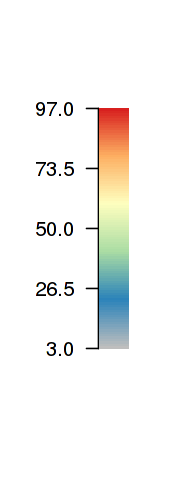

In [11]:
rbPal <- colorRampPalette(c('gray','#2b83ba','#abdda4','#ffffbf','#fdae61','#d7191c'))
options(repr.plot.width=1.5, repr.plot.height=4)
color.bar(rbPal(100), 3,97,nticks=5)

In [4]:
ExpressionMat_magic=readRDS("ExpressionMat_magic.rds")
#supercell=readRDS("Exp_pseudoCell_nofilter.rds")

In [6]:
ExpressionMat_magic_gut=ExpressionMat_magic[match(rownames(Exp_Seurat_Gut@meta.data),rownames(ExpressionMat_magic)),]
ExpressionMat_magic_spleen=ExpressionMat_magic[match(rownames(Exp_Seurat_Spleen@meta.data),rownames(ExpressionMat_magic)),]

In [81]:
tag_gene=c("Il7r","Klrg1","Prdm1","Tbx21","Zeb2","Id2","Bcl6","Eomes","Tcf7","Id3","Havcr2","Itgam","Gzmb","Cd160","Slamf6")
tag_gene=tag_gene[tag_gene %in% colnames(ExpressionMat_magic)]
tag_gene=tag_gene[gtools::mixedorder(tag_gene)]

selected=sample(1:nrow(ExpressionMat_magic_gut),5000) #as.numeric(rownames(supercell))

In [82]:
#plot on TRM only
tagExpressionNormed=ExpressionMat_magic_gut[selected,tag_gene]
rtsne_normed=Exp_Seurat_Gut@dr$tsne@cell.embeddings[selected,]

pdf("per gene TPM TSNE_magic TRM only.pdf",width=22,height=11)
par(mfrow=c(3,6))
for(i in 1:ncol(tagExpressionNormed)){
  currentid=colnames(tagExpressionNormed)[i]
        #calculate breaks
        lowerbound=sort(tagExpressionNormed[,i])[round(nrow(tagExpressionNormed)/33)]
        upperbound=sort(tagExpressionNormed[,i])[round(nrow(tagExpressionNormed)/33*32)]
        if(upperbound!=lowerbound){
            breaks=c(min(tagExpressionNormed[,i])-1,seq(lowerbound, upperbound, length.out=25),max(tagExpressionNormed[,i])+1)
            cols=rbPal(25)[as.numeric(cut(tagExpressionNormed[,i],breaks = breaks, include.lowest=TRUE))]
        }else{
            breaks=c(min(tagExpressionNormed[,i])-1,max(tagExpressionNormed[,i])/2,max(tagExpressionNormed[,i]))
            cols=rbPal(2)[as.numeric(cut(tagExpressionNormed[,i],breaks = breaks, include.lowest=TRUE))]
        }
  plot(rtsne_normed,pch=19,cex=0.35,col=cols,main=currentid)  
}
dev.off()

png 
  2

In [83]:
tag_gene=c("Il7r","Klrg1","Prdm1","Tbx21","Zeb2","Id2","Bcl6","Eomes","Tcf7","Id3","Havcr2","Itgam","Gzmb","Cd160","Slamf6")
tag_gene=tag_gene[tag_gene %in% colnames(ExpressionMat_magic)]
tag_gene=tag_gene[gtools::mixedorder(tag_gene)]

selected=sample(1:nrow(ExpressionMat_magic_spleen),5000) #as.numeric(rownames(supercell))

In [84]:
#plot on TRM only
tagExpressionNormed=ExpressionMat_magic_spleen[selected,tag_gene]
rtsne_normed=Exp_Seurat_Spleen@dr$tsne@cell.embeddings[selected,]

pdf("per gene TPM TSNE_magic Spleen only.pdf",width=22,height=11)
par(mfrow=c(3,6))
for(i in 1:ncol(tagExpressionNormed)){
  currentid=colnames(tagExpressionNormed)[i]
        #calculate breaks
        lowerbound=sort(tagExpressionNormed[,i])[round(nrow(tagExpressionNormed)/33)]
        upperbound=sort(tagExpressionNormed[,i])[round(nrow(tagExpressionNormed)/33*32)]
        if(upperbound!=lowerbound){
            breaks=c(min(tagExpressionNormed[,i])-1,seq(lowerbound, upperbound, length.out=25),max(tagExpressionNormed[,i])+1)
            cols=rbPal(25)[as.numeric(cut(tagExpressionNormed[,i],breaks = breaks, include.lowest=TRUE))]
        }else{
            breaks=c(min(tagExpressionNormed[,i])-1,max(tagExpressionNormed[,i])/2,max(tagExpressionNormed[,i]))
            cols=rbPal(2)[as.numeric(cut(tagExpressionNormed[,i],breaks = breaks, include.lowest=TRUE))]
        }
  plot(rtsne_normed,pch=19,cex=0.35,col=cols,main=currentid)  
}
dev.off()

png 
  2

### per timepoint plot

In [7]:
tag_gene=c("Id3","Prdm1","Slamf6","Tbx21","Zeb2","Bcl6","Id2","Eomes","Tcf7")
tag_gene=tag_gene[tag_gene %in% colnames(ExpressionMat_magic)]
tag_gene=tag_gene[gtools::mixedorder(tag_gene)]

selected=sample(1:nrow(ExpressionMat_magic_gut),5000) #as.numeric(rownames(supercell))
tag_time=c("D4","D7","D10","D14","D21","D32","D60")

In [12]:
#plot on TRM only
tagExpressionNormed=ExpressionMat_magic_gut[selected,tag_gene]
rtsne_normed=Exp_Seurat_Gut@dr$tsne@cell.embeddings[selected,]

pdf("per gene TPM TSNE_magic TRM only_seperateByTime.pdf",width=22,height=11)
par(mfrow=c(3,6))
for(i in 1:ncol(tagExpressionNormed)){
  currentid=colnames(tagExpressionNormed)[i]
        #calculate breaks
        lowerbound=sort(tagExpressionNormed[,i])[round(nrow(tagExpressionNormed)/33)]
        upperbound=sort(tagExpressionNormed[,i])[round(nrow(tagExpressionNormed)/33*32)]
        if(upperbound!=lowerbound){
            breaks=c(min(tagExpressionNormed[,i])-1,seq(lowerbound, upperbound, length.out=25),max(tagExpressionNormed[,i])+1)
            cols=rbPal(25)[as.numeric(cut(tagExpressionNormed[,i],breaks = breaks, include.lowest=TRUE))]
        }else{
            breaks=c(min(tagExpressionNormed[,i])-1,max(tagExpressionNormed[,i])/2,max(tagExpressionNormed[,i]))
            cols=rbPal(2)[as.numeric(cut(tagExpressionNormed[,i],breaks = breaks, include.lowest=TRUE))]
        }
    for(j in 1:length(tag_time)){
        tagC=which(Exp_Seurat_Gut@meta.data$timepoint[selected] == tag_time[j])
        plot(rtsne_normed[-tagC,],pch=19,cex=0.35,col="gray",main=paste0(currentid,"_", tag_time[j]),) 
        points(rtsne_normed[tagC,],pch=19,cex=0.35,col=cols[tagC])
    }
}
dev.off()


png 
  2

### Violin for both

In [ ]:
ExpressionMat_magic=readRDS("ExpressionMat_magic.rds")
supercell=readRDS("Exp_pseudoCell_nofilter.rds")

In [44]:
tagG=c("Il7r","Klrg1")
tagG=tagG[tagG %in% colnames(supercell)]
tagG=tagG[gtools::mixedorder(tagG)]

tagC=as.numeric(rownames(supercell))
tag_inC=tagC %in% which(Exp_Seurat@meta.data$timepoint %in% c("d4","d7","d10","d14","d21","d32","d60"))
tagC=tagC[tag_inC]

In [45]:
eigen_vec_wide=cbind(batchidx[Exp_Seurat@meta.data$batch[tagC]],
                     Exp_Seurat@meta.data$tissue[tagC],
                     Exp_Seurat@meta.data$timepoint[tagC],
                     as.data.frame(supercell[tag_inC,tagG]))
colnames(eigen_vec_wide)[1:3]=c("batch_id","tissue","time_point")

eigen_vec_wide=data.table(eigen_vec_wide)
eigen_vec_tall=melt(eigen_vec_wide, id.vars = c("batch_id","tissue","time_point"),
                    measure.vars = setdiff(colnames(eigen_vec_wide),c("batch_id","tissue","time_point")),
                    variable.name="gene",value.name="expression_level")

eigen_vec_tall$tissue=factor(eigen_vec_tall$tissue,levels=tissue_types)
eigen_vec_tall$time_point=factor(eigen_vec_tall$time_point,levels=time_points)

eigen_vec_tall_gut=eigen_vec_tall[eigen_vec_tall$tissue=="Gut",]
eigen_vec_tall_spleen=eigen_vec_tall[eigen_vec_tall$tissue=="Spleen",]

pdf(paste0("gene expression violin_bothSpleen&Gut_supercell.pdf"),width=8,height=5)
for(i in 1:length(tagG)){
    tag_tbl_spleen=eigen_vec_tall_spleen[eigen_vec_tall_spleen$gene==tagG[i],]
    tag_tbl_gut=eigen_vec_tall_gut[eigen_vec_tall_gut$gene==tagG[i],]
    tmp=ggplot() + 
      geom_violin(data=tag_tbl_spleen,aes(x=time_point, y=expression_level, fill=tissue), alpha = 0.5) +
      geom_violin(data=tag_tbl_gut,aes(x=time_point, y=expression_level, fill=tissue), alpha = 0.5) +
      theme(axis.text.x = element_text(angle = 60, hjust = 1)) +
      ggtitle(paste0("gene expression level of ",tagG[i])) + labs(y = "TPM level") + 
      scale_fill_manual(values = tissue_color,
                        name="tissue origin",
                        breaks=c("Spleen", "Gut"),
                        labels=c("spleen", "gut"))
    print(tmp)
    }
dev.off()

png 
  2

In [46]:
eigen_vec_wide=cbind(batchidx[Exp_Seurat@meta.data$batch[tagC]],
                     Exp_Seurat@meta.data$tissue[tagC],
                     Exp_Seurat@meta.data$timepoint[tagC],
                     as.data.frame(ExpressionMat_magic[tagC,tagG]))
colnames(eigen_vec_wide)[1:3]=c("batch_id","tissue","time_point")

eigen_vec_wide=data.table(eigen_vec_wide)
eigen_vec_tall=melt(eigen_vec_wide, id.vars = c("batch_id","tissue","time_point"),
                    measure.vars = setdiff(colnames(eigen_vec_wide),c("batch_id","tissue","time_point")),
                    variable.name="gene",value.name="expression_level")

eigen_vec_tall$tissue=factor(eigen_vec_tall$tissue,levels=tissue_types)
eigen_vec_tall$time_point=factor(eigen_vec_tall$time_point,levels=time_points)

eigen_vec_tall_gut=eigen_vec_tall[eigen_vec_tall$tissue=="Gut",]
eigen_vec_tall_spleen=eigen_vec_tall[eigen_vec_tall$tissue=="Spleen",]

pdf(paste0("gene expression violin_bothSpleen&Gut_MAGIC.pdf"),width=8,height=5)
for(i in 1:length(tagG)){
    tag_tbl_spleen=eigen_vec_tall_spleen[eigen_vec_tall_spleen$gene==tagG[i],]
    tag_tbl_gut=eigen_vec_tall_gut[eigen_vec_tall_gut$gene==tagG[i],]
    tmp=ggplot() + 
      geom_violin(data=tag_tbl_spleen,aes(x=time_point, y=expression_level, fill=tissue), alpha = 0.5) +
      geom_violin(data=tag_tbl_gut,aes(x=time_point, y=expression_level, fill=tissue), alpha = 0.5) +
      theme(axis.text.x = element_text(angle = 60, hjust = 1)) +
      ggtitle(paste0("gene expression level of ",tagG[i])) + labs(y = "magiced gene expression level") + 
      scale_fill_manual(values = tissue_color,
                        name="tissue origin",
                        breaks=c("Spleen", "Gut"),
                        labels=c("spleen", "gut"))
    print(tmp)
    }
dev.off()

png 
  2

### Violin for Gut

In [50]:
tagG=c("Il7r","Klrg1","Prdm1","Tbx21","Zeb2","Id2","Bcl6","Eomes","Tcf7","Id3","Havcr2","Itgam","Gzmb","Cd160")
tagG=tagG[tagG %in% colnames(supercell)]
tagG=tagG[gtools::mixedorder(tagG)]

tagC=as.numeric(rownames(supercell))
tag_inC=tagC %in% which(Exp_Seurat@meta.data$timepoint %in% c("d4","d7","d10","d14","d21","d32","d60"))
tagC=tagC[tag_inC]

In [51]:
eigen_vec_wide=cbind(batchidx[Exp_Seurat@meta.data$batch[tagC]],
                     Exp_Seurat@meta.data$tissue[tagC],
                     Exp_Seurat@meta.data$timepoint[tagC],
                     as.data.frame(supercell[tag_inC,tagG]))
colnames(eigen_vec_wide)[1:3]=c("batch_id","tissue","time_point")

eigen_vec_wide=data.table(eigen_vec_wide)
eigen_vec_tall=melt(eigen_vec_wide, id.vars = c("batch_id","tissue","time_point"),
                    measure.vars = setdiff(colnames(eigen_vec_wide),c("batch_id","tissue","time_point")),
                    variable.name="gene",value.name="expression_level")

eigen_vec_tall$tissue=factor(eigen_vec_tall$tissue,levels=tissue_types)
eigen_vec_tall$time_point=factor(eigen_vec_tall$time_point,levels=time_points)

eigen_vec_tall_gut=eigen_vec_tall[eigen_vec_tall$tissue=="Gut",]
eigen_vec_tall_spleen=eigen_vec_tall[eigen_vec_tall$tissue=="Spleen",]

pdf(paste0("gene expression violin_Gut_supercell.pdf"),width=8,height=5)
for(i in 1:length(tagG)){
    tag_tbl_gut=eigen_vec_tall_gut[eigen_vec_tall_gut$gene==tagG[i],]
    tmp=ggplot() + 
      geom_violin(data=tag_tbl_gut,aes(x=time_point, y=expression_level, fill=tissue), alpha = 0.5) +
      theme(axis.text.x = element_text(angle = 60, hjust = 1)) +
      ggtitle(paste0("gene expression level of ",tagG[i])) + labs(y = "TPM level") + 
      scale_fill_manual(values = tissue_color,
                        name="tissue origin",
                        breaks=c( "Gut"),
                        labels=c("gut"))
    print(tmp)
    }
dev.off()

png 
  2

In [52]:
eigen_vec_wide=cbind(batchidx[Exp_Seurat@meta.data$batch[tagC]],
                     Exp_Seurat@meta.data$tissue[tagC],
                     Exp_Seurat@meta.data$timepoint[tagC],
                     as.data.frame(ExpressionMat_magic[tagC,tagG]))
colnames(eigen_vec_wide)[1:3]=c("batch_id","tissue","time_point")

eigen_vec_wide=data.table(eigen_vec_wide)
eigen_vec_tall=melt(eigen_vec_wide, id.vars = c("batch_id","tissue","time_point"),
                    measure.vars = setdiff(colnames(eigen_vec_wide),c("batch_id","tissue","time_point")),
                    variable.name="gene",value.name="expression_level")

eigen_vec_tall$tissue=factor(eigen_vec_tall$tissue,levels=tissue_types)
eigen_vec_tall$time_point=factor(eigen_vec_tall$time_point,levels=time_points)

eigen_vec_tall_gut=eigen_vec_tall[eigen_vec_tall$tissue=="Gut",]
eigen_vec_tall_spleen=eigen_vec_tall[eigen_vec_tall$tissue=="Spleen",]

pdf(paste0("gene expression violin_Gut_MAGIC.pdf"),width=8,height=5)
for(i in 1:length(tagG)){
    tag_tbl_gut=eigen_vec_tall_gut[eigen_vec_tall_gut$gene==tagG[i],]
    tmp=ggplot() + 
      geom_violin(data=tag_tbl_gut,aes(x=time_point, y=expression_level, fill=tissue), alpha = 0.5) +
      theme(axis.text.x = element_text(angle = 60, hjust = 1)) +
      ggtitle(paste0("gene expression level of ",tagG[i])) + labs(y = "TPM level") + 
      scale_fill_manual(values = tissue_color,
                        name="tissue origin",
                        breaks=c( "Gut"),
                        labels=c("gut"))
    print(tmp)
    }
dev.off()

png 
  2